Loading train/test splits...

--- Seed 0 ---
Best Hyperparams for seed 0: {'hidden_dim': 128, 'dropout_rate': 0.2}

--- Seed 1 ---
Best Hyperparams for seed 1: {'hidden_dim': 128, 'dropout_rate': 0.2}

--- Seed 2 ---
Best Hyperparams for seed 2: {'hidden_dim': 128, 'dropout_rate': 0.3}

--- Seed 3 ---
Best Hyperparams for seed 3: {'hidden_dim': 128, 'dropout_rate': 0.3}

--- Seed 4 ---
Best Hyperparams for seed 4: {'hidden_dim': 128, 'dropout_rate': 0.2}

--- Seed 5 ---
Best Hyperparams for seed 5: {'hidden_dim': 128, 'dropout_rate': 0.2}

--- Seed 6 ---
Best Hyperparams for seed 6: {'hidden_dim': 128, 'dropout_rate': 0.3}

--- Seed 7 ---
Best Hyperparams for seed 7: {'hidden_dim': 128, 'dropout_rate': 0.2}

--- Seed 8 ---
Best Hyperparams for seed 8: {'hidden_dim': 128, 'dropout_rate': 0.2}

--- Seed 9 ---
Best Hyperparams for seed 9: {'hidden_dim': 128, 'dropout_rate': 0.3}

--- Seed 10 ---
Best Hyperparams for seed 10: {'hidden_dim': 128, 'dropout_rate': 0.2}

--- Seed 11 ---
Best H

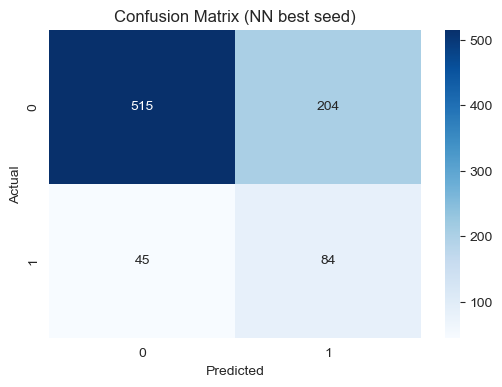


=== Summary over seeds ===
           seed  hidden_dim  dropout_rate  best_threshold    best_f1
count  20.00000        20.0     20.000000       20.000000  20.000000
mean    9.50000       128.0      0.240000        0.558081   0.388917
std     5.91608         0.0      0.050262        0.036031   0.006970
min     0.00000       128.0      0.200000        0.484848   0.379121
25%     4.75000       128.0      0.200000        0.542929   0.383391
50%     9.50000       128.0      0.200000        0.555556   0.389542
75%    14.25000       128.0      0.300000        0.585859   0.392092
max    19.00000       128.0      0.300000        0.626263   0.402878
Saved results to ../results/nn_subsampling_thresholds.csv


In [19]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import KFold
from sklearn.utils import resample

print("Loading train/test splits...")
X_train = np.load("../data/splits/X_train.npy")
y_train = np.load("../data/splits/y_train.npy")
X_test = np.load("../data/splits/X_test.npy")
y_test = np.load("../data/splits/y_test.npy")

class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_rate):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

param_grid = {
    'hidden_dim': [32, 64, 128],
    'dropout_rate': [0.2, 0.3, 0.5]
}

results = []
models = []
probs_list = []
thresh_list = []

for seed in range(20):
    print(f"\n--- Seed {seed} ---")

    X_train_df = pd.DataFrame(X_train)
    y_train_df = pd.Series(y_train)

    X_minority = X_train_df[y_train_df == 1]
    y_minority = y_train_df[y_train_df == 1]

    X_majority = X_train_df[y_train_df == 0]
    y_majority = y_train_df[y_train_df == 0]

    X_majority_down, y_majority_down = resample(X_majority, y_majority,
                                                replace=False,
                                                n_samples=len(X_minority),
                                                random_state=seed)

    X_res = pd.concat([X_majority_down, X_minority])
    y_res = pd.concat([y_majority_down, y_minority])

    X_t = torch.tensor(X_res.values, dtype=torch.float32)
    y_t = torch.tensor(y_res.values, dtype=torch.float32).unsqueeze(1)

    X_test_t = torch.tensor(X_test, dtype=torch.float32)
    y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    best_loss = float('inf')
    best_params = {}
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)

    for h in param_grid['hidden_dim']:
        for d in param_grid['dropout_rate']:
            val_losses = []
            for train_idx, val_idx in kf.split(X_t):
                model = SimpleNN(X_t.shape[1], h, d)
                opt = optim.Adam(model.parameters(), lr=0.001)
                crit = nn.BCEWithLogitsLoss()

                for _ in range(20):
                    model.train()
                    opt.zero_grad()
                    loss = crit(model(X_t[train_idx]), y_t[train_idx])
                    loss.backward()
                    opt.step()

                model.eval()
                with torch.no_grad():
                    val_loss = crit(model(X_t[val_idx]), y_t[val_idx]).item()
                    val_losses.append(val_loss)

            avg_val_loss = np.mean(val_losses)
            if avg_val_loss < best_loss:
                best_loss = avg_val_loss
                best_params = {'hidden_dim': h, 'dropout_rate': d}

    print(f"Best Hyperparams for seed {seed}: {best_params}")

    model = SimpleNN(X_t.shape[1], best_params['hidden_dim'], best_params['dropout_rate'])
    opt = optim.Adam(model.parameters(), lr=0.001)
    crit = nn.BCEWithLogitsLoss()

    for _ in range(20):
        model.train()
        opt.zero_grad()
        loss = crit(model(X_t), y_t)
        loss.backward()
        opt.step()

    model.eval()
    with torch.no_grad():
        logits = model(X_test_t)
        probs = torch.sigmoid(logits).squeeze().numpy()

    thresholds = np.linspace(0, 1, 100)
    f1_scores = [f1_score(y_test, (probs >= t).astype(int)) for t in thresholds]
    best_idx = np.argmax(f1_scores)
    best_thresh = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]

    results.append({'seed': seed,
                    'hidden_dim': best_params['hidden_dim'],
                    'dropout_rate': best_params['dropout_rate'],
                    'best_threshold': best_thresh,
                    'best_f1': best_f1})

    models.append(model)
    probs_list.append(probs)
    thresh_list.append(best_thresh)

# Select best model
best_idx = np.argmax([r['best_f1'] for r in results])
final_model = models[best_idx]
final_thresh = thresh_list[best_idx]
final_probs = probs_list[best_idx]

final_preds = (final_probs >= final_thresh).astype(int)

print("\nClassification Report (best seed):")
print(classification_report(y_test, final_preds))

cm = confusion_matrix(y_test, final_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (NN best seed)")
plt.show()

results_df = pd.DataFrame(results)
print("\n=== Summary over seeds ===")
print(results_df.describe())

os.makedirs("../results", exist_ok=True)
results_df.to_csv("../results/nn_subsampling_thresholds.csv", index=False)
print("Saved results to ../results/nn_subsampling_thresholds.csv")